In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [2]:
from ipywidgets import IntProgress
from IPython.display import display

In [3]:
from model_builder import ModelBuilder
from solve_action import SolveAction

In [4]:
from pyomo_values_converter import PyomoValuesConverter

In [5]:
from dependencies_calculator import DependenciesCalculator
from cost_calculator_factory import CostCalculatorFactory
from multibinary_converter import MultiBinaryConverter
from multidiscrete_converter import MultiDiscreteConverter
from fitness_calculator import FitnessCalculator

In [6]:
from genetic_multibinary_space_config import GeneticMultiBinarySpaceConfig
from genetic_multidiscrete_space_config import GeneticMultiDiscreteSpaceConfig
from genetic_config import GeneticConfig
from genetic_solver import GeneticSolver

In [7]:
from stable_baselines3 import PPO
from stable_baselines3 import A2C
from stable_baselines3.common.env_checker import check_env

In [8]:
from rl_multibinary_config import RlMultiBinaryConfig
from rl_multidiscrete_config import RlMultiDiscreteConfig
from rl_graphic import RlGraphic
from rl_env import RlEnv
from rl_solver import RlSolver

In [9]:
dtype = np.int64

In [10]:
import warnings
warnings.filterwarnings("ignore")

In [11]:
M = 10 ** 6

In [12]:
read_matrix = lambda path: pd.read_csv(path, index_col=0, encoding='utf-8').to_numpy()

In [13]:
C = read_matrix('../publication_4/script/out/C.csv')

In [14]:
D = read_matrix('../publication_4/script/out/D.csv')

In [15]:
Q = read_matrix('../publication_4/script/out/Q.csv')

In [16]:
R = read_matrix('../publication_4/script/out/R.csv')

In [17]:
constants_file = open('../publication_4/script/out/constants.json', 'r', encoding='utf-8')
constants_data = constants_file.read()
constants_file.close()
constants = json.loads(constants_data)

In [18]:
n = constants['n']
m = constants['m']
l = constants['l']

In [19]:
# solver_name = 'cbc'

In [20]:
calculate_deps_progress = IntProgress(min=0, max=m, value=0, description='deps', bar_style='success')
display(calculate_deps_progress)
deps_calculator = DependenciesCalculator(D, m, calculate_deps_progress)
sum_D = deps_calculator.calculate()

IntProgress(value=0, bar_style='success', description='deps', max=124)

In [21]:
class CalculateResult():
    def __init__(self, cost, duration):
        self.cost = cost
        self.duration = duration

In [22]:
def genetic_calculate(k, R):
    config = GeneticConfig()
    config.num_generations = 1000
    multidiscrete_converter = MultiDiscreteConverter(m, k)
    cost_calculator_factory = CostCalculatorFactory(Q, sum_D, C, R)
    multidiscrete_fitness_calculator = FitnessCalculator(M, cost_calculator_factory, multidiscrete_converter)
    multidiscrete_space_config = GeneticMultiDiscreteSpaceConfig(m, k)
    multidiscrete_config = GeneticConfig()
    multibinary_progress = IntProgress(min=0, max=config.num_generations, value=0, description=str(k), bar_style='success')
    multidiscrete_genetic_solver = GeneticSolver(config, multidiscrete_space_config, multidiscrete_fitness_calculator, multibinary_progress)
    # display(multibinary_progress)
    best_solution, best_fitness, best_idx, duration = multidiscrete_genetic_solver.solve()
    A = multidiscrete_converter.convert(best_solution)
    cost_calculator = cost_calculator_factory.get_cost_calculator(A)
    cost = cost_calculator.calculate()
    calculate_result = CalculateResult(cost, duration)
    return calculate_result

In [23]:
def rl_calculate(k, R):
    total_timesteps = 1000
    cost_calculator_factory = CostCalculatorFactory(Q, sum_D, C, R)
    multidiscrete_config = RlMultiDiscreteConfig(m, k, dtype)
    multidiscrete_converter = MultiDiscreteConverter(m, k)
    multidiscrete_fitness_calculator = FitnessCalculator(M, cost_calculator_factory, multidiscrete_converter)
    multidiscrete_progress = IntProgress(min=0, max=total_timesteps, value=0, description=str(k), bar_style='success')
    display(multidiscrete_progress)
    multidiscrete_graphic = RlGraphic('multidiscrete')
    multidiscrete_optimisation_task_env = RlEnv(M, multidiscrete_config, multidiscrete_fitness_calculator, multidiscrete_progress, multidiscrete_graphic)
    check_env(multidiscrete_optimisation_task_env)
    multidiscrete_model = A2C("MlpPolicy", multidiscrete_optimisation_task_env)
    rl_multidiscrete_solver = RlSolver(multidiscrete_model, total_timesteps)
    best_fitness, best_solution, duration = rl_multidiscrete_solver.solve()
    X = multidiscrete_converter.convert(best_solution)
    cost_calculator = cost_calculator_factory.get_cost_calculator(X)
    cost = cost_calculator.calculate()
    calculate_result = CalculateResult(cost, duration)
    return calculate_result

In [24]:
def solver_calculate(k, R, solver_name):
    model_builder = ModelBuilder(M, k, Q, sum_D, C, R)
    model = model_builder.build()
    # solver_name = 'glpk'
    solve_action = SolveAction(model, solver_name)
    solve_result = solve_action.solve()
    instance = solve_result.instance
    duration = solve_result.duration
    pyomo_values_converter = PyomoValuesConverter()
    X = pyomo_values_converter.convert(instance.A)
    cost_calculator_factory = CostCalculatorFactory(Q, sum_D, C, R)
    cost_calculator = cost_calculator_factory.get_cost_calculator(X)
    cost = cost_calculator.calculate()
    calculate_result = CalculateResult(cost, duration)
    return calculate_result

In [25]:
def make_comparation():
    _R = np.array([R[0]])

    genetic_cost = []
    genetic_duration = []

    rl_cost = []
    rl_duration = []
    
    glpk_solver_cost = []
    glpk_solver_duration = []
    
    cbc_solver_cost = []
    cbc_solver_duration = []

    count = 10
    progress = IntProgress(min=0, max=count, value=0, description='progress', bar_style='success')
    display(progress)
    
    for k in range(1, count + 1):
        genetic_calculate_result = genetic_calculate(k, _R)
        # rl_calculate_result = rl_calculate(k, _R)
        # glpk_solver_calculate_result = solver_calculate(k, _R, 'glpk')
        # cbc_solver_calculate_result = solver_calculate(k, _R, 'cbc')

        genetic_cost.append(genetic_calculate_result.cost)
        genetic_duration.append(genetic_calculate_result.duration)

        # rl_cost.append(rl_calculate_result.cost)
        # rl_duration.append(rl_calculate_result.duration)
        
        # glpk_solver_cost.append(glpk_solver_calculate_result.cost)
        # glpk_solver_duration.append(glpk_solver_calculate_result.duration)
        
        # cbc_solver_cost.append(cbc_solver_calculate_result.cost)
        # cbc_solver_duration.append(cbc_solver_calculate_result.duration)
        
        progress.value += 1

    # data = {
    #     'genetic_cost': genetic_cost,
    #     'genetic_duration': genetic_duration,
    #     'solver_cost': solver_cost,
    #     'solver_duration': solver_duration
    # }

    # data = {
    #     'glpk_cost': glpk_solver_cost,
    #     'glpk_duration': glpk_solver_duration,
    #     'cbc_cost': cbc_solver_cost,
    #     'cbc_duration': cbc_solver_duration
    # }

    data = {
        'genetic_cost': genetic_cost,
        'genetic_duration': genetic_duration,
        # 'rl_cost': rl_cost,
        # 'rl_duration': rl_duration
    }
    
    df = pd.DataFrame(data)
    return df

In [114]:
comparation_df = make_comparation()

IntProgress(value=0, bar_style='success', description='progress', max=10)

In [115]:
comparation_df

,genetic_cost,genetic_duration
0,150.0,1.313475
1,150.0,2.005591
2,150.0,1.865640
3,150.0,1.959104
4,150.0,2.032774
5,150.0,2.004860
6,150.0,1.804141
7,150.0,1.758462
8,136.0,2.124440
9,150.0,1.987481


In [75]:
comparation_df.to_csv('out_4/comparation.csv')

In [26]:
def save_k_costs(k, costs):
    file = open('out_4/k_costs.json', 'r', encoding='utf-8')
    data = file.read()
    file.close()
    d = json.loads(data)
    d[str(k)] = costs
    data = json.dumps(d, indent=4)
    file = open('out_4/k_costs.json', 'w', encoding='utf-8')
    file.write(data)
    file.close()

In [27]:
def make_genetic(k):
    iterations = 100
    progress = IntProgress(min=0, max=iterations, value=0, description=str(k), bar_style='success')
    display(progress)
    costs = []
    for _ in range(iterations):
        genetic_calculate_result = genetic_calculate(k, R)
        cost = genetic_calculate_result.cost
        costs.append(cost)
        progress.value += 1
    save_k_costs(k, costs)

In [46]:
def make_rl(k):
    rl_calculate_result = rl_calculate(k, R)
    cost = rl_calculate_result.cost
    return cost

In [28]:
for k in range(1, 51):
    pass
    # make(k)

In [48]:
rl_costs = []

In [84]:
rl_df = pd.read_csv('out_4/rl_df.csv', encoding='utf-8')

In [85]:
if False:
    current_step = 1
    steps_count = 50
    rl_progress = IntProgress(min=0, max=steps_count, value=0, description='rl', bar_style='success')
    display(rl_progress)
    for k in range(current_step, current_step + steps_count):
        cost = make_rl(k)
        rl_costs.append(cost)
        rl_progress.value += 1
    rl_dict = {'rl': rl_costs}
    rl_df = pd.DataFrame(rl_dict)
    length = len(rl_df)
    rl_df.index = range(1, length + 1)
    rl_df.to_csv('out_4/rl_df.csv', encoding='utf-8')

In [86]:
k_cost_file = open('out_4/k_costs.json', 'r', encoding='utf-8')
k_cost_data = k_cost_file.read()
k_cost_file.close()

In [87]:
k_cost = json.loads(k_cost_data)

In [88]:
k_cost_df = pd.DataFrame(k_cost)

In [89]:
k_cost_df.describe()

,1,2,3,4,5,6,7,8,9,10,...,41,42,43,44,45,46,47,48,49,50
count,100.0,100.00,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,...,100.000000,100.0000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,100.000000,100.000000
mean,1500.0,1498.85,1476.880000,1421.260000,1363.030000,1303.110000,1252.040000,1201.750000,1150.340000,1128.280000,...,634.850000,627.1900,615.350000,614.460000,613.29000,608.080000,601.930000,604.360000,596.200000,592.720000
std,0.0,11.50,43.352975,50.704655,56.675838,62.914708,63.582432,53.199904,57.948291,54.295875,...,26.631179,27.1467,28.087301,30.640773,31.51376,29.324613,27.700511,25.052075,26.736273,24.002138
min,1500.0,1385.00,1370.000000,1288.000000,1224.000000,1150.000000,1053.000000,1088.000000,1014.000000,960.000000,...,568.000000,557.0000,554.000000,547.000000,546.00000,540.000000,551.000000,532.000000,542.000000,544.000000
25%,1500.0,1500.00,1500.000000,1392.750000,1319.500000,1260.250000,1215.750000,1164.750000,1112.750000,1091.000000,...,616.000000,609.0000,596.500000,592.750000,587.75000,584.750000,580.000000,586.000000,579.000000,575.000000
50%,1500.0,1500.00,1500.000000,1413.000000,1379.000000,1304.000000,1256.000000,1208.000000,1152.000000,1141.500000,...,635.000000,622.0000,612.000000,610.000000,615.00000,608.000000,599.500000,603.500000,594.000000,592.000000
75%,1500.0,1500.00,1500.000000,1448.500000,1405.250000,1346.000000,1300.750000,1234.000000,1192.750000,1168.250000,...,653.500000,646.5000,632.000000,631.000000,631.50000,625.250000,623.250000,624.250000,613.250000,608.000000
max,1500.0,1500.00,1500.000000,1500.000000,1500.000000,1427.000000,1359.000000,1340.000000,1257.000000,1229.000000,...,708.000000,721.0000,701.000000,703.000000,678.00000,688.000000,664.000000,653.000000,664.000000,658.000000


In [90]:
k_cost_df.to_csv('out_4/dataframe.csv')

In [91]:
genetic_max_values = [k_cost_df[stb].max() for stb in k_cost_df.columns]
genetc_min_values = [k_cost_df[stb].min() for stb in k_cost_df.columns]
genetic_mean_values = [k_cost_df[stb].mean() for stb in k_cost_df.columns]
rl_values = list(rl_df['rl'])

In [92]:
values_dict = {
    'genetic: max': genetic_max_values,
    'genetic: min': genetc_min_values,
    'genetic: mean': genetic_mean_values,
    'RL': rl_values
}

In [93]:
values_df = pd.DataFrame(values_dict)

In [94]:
values_df.index = range(1, 51)

Text(0, 0.5, 'Суммарная стоимость')

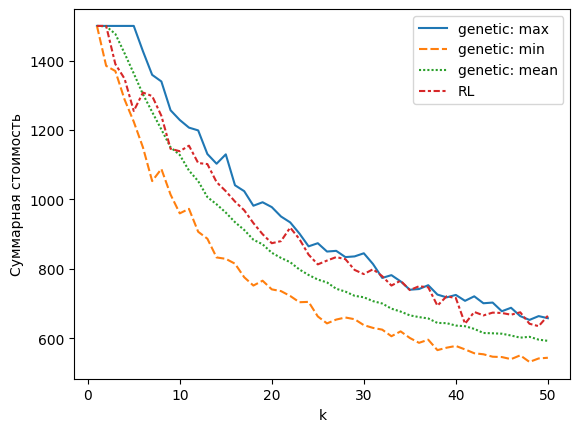

In [95]:
sns.lineplot(data=values_df)
plt.xlabel('k')
plt.ylabel('Суммарная стоимость')